# Cross-validation lung data
Does five-fold crossvalidation in annotating lung data to get stability of different algorithms

In [1]:
import os, sys

import anndata
import numpy as np
import scanpy as sc
from scanpy.plotting import palettes
sys.path.insert(0, '../../PopV')
import popv

From /home/cane/miniconda3/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
Created a temporary directory at /tmp/tmp5we747gd
Writing /tmp/tmp5we747gd/_remote_module_non_scriptable.py
Global seed set to 0


In [2]:
popv.__file__

'/data/extra_files/galen_dropbox_figures/can_reproducibility/lung_models/lung_cv/../../PopV/popv/__init__.py'

## Run PopV

In [3]:
refdata_url = '"https://zenodo.org/record/7587774/files/TS_Lung_filtered.h5ad?download"'
lung_fn = 'data/Lung.h5ad'
if not os.path.exists(lung_fn):
    !wget -O $lung_fn $refdata_url

lung = anndata.read(lung_fn)

In [4]:
lung

AnnData object with n_obs × n_vars = 35672 × 58559
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay'
    var: 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'

In [5]:
query_index = np.random.choice([0,1,2,3,4], size = len(lung), replace=True)

In [6]:
for i in range(0,5):
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    lung[query_index!=i].write(ref_adata_path)
    lung[query_index==i].write(query_adata_path)

In [7]:
save_folder = 'popv_results'
query_batch_key = 'donor_assay'

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Following parameters are specific to Tabula Sapiens dataset
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [8]:
from popv.preprocessing import Process_Query
from popv.annotation import annotate_data

In [ ]:
for i in range(0,5):
    print(i)
    save_folder = f'cv_run_{i}/popv_results_{i}'
    if not os.path.exists(f'cv_run_{i}'):
        os.mkdir(f'cv_run_{i}')
    
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    
    # read in the reference dataset
    ref_adata = anndata.read(ref_adata_path)
    query_adata = anndata.read(query_adata_path)
    
    min_celltype_size = np.min(ref_adata.obs.groupby('cell_ontology_class').size())
    n_samples_per_label = np.max((min_celltype_size, 100))
    
    adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'cv_run_{i}/pretrained_models/',
        cl_obo_folder='../../PopV/ontology/',
        pretrained_scvi_path=None,
        prediction_mode='retrain',
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=4000
    ).adata
    
    annotate_data(adata, save_path=save_folder)
    adata.write(f'cv_run_{i}/annotated_query.h5ad')

## Evaluate results

In [3]:
lung = sc.read('data/Lung.h5ad')

In [4]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = list(set(list(query.uns['prediction_keys']) + list(query.uns['prediction_keys_seen'])))

In [5]:
lung.obs['cv_prediction'] = 'na'

for k in pred_keys:
    lung.obs[k] = 'na'

lung.obs['cv_idx'] = 'na'

In [6]:
names = []
for i in range(5):
    print(i)
    query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
    names.append(query.obs_names)
    lung.obs.loc[query.obs_names, 'cv_prediction'] = query.obs['popv_prediction'].astype('str')
    lung.obs.loc[query.obs_names, 'cv_idx'] = str(i)
    for k in pred_keys:
        lung.obs.loc[query.obs_names, k] = query.obs[k].astype('str')

0
1
2
3
4


Making confusion matrix for cv_prediction


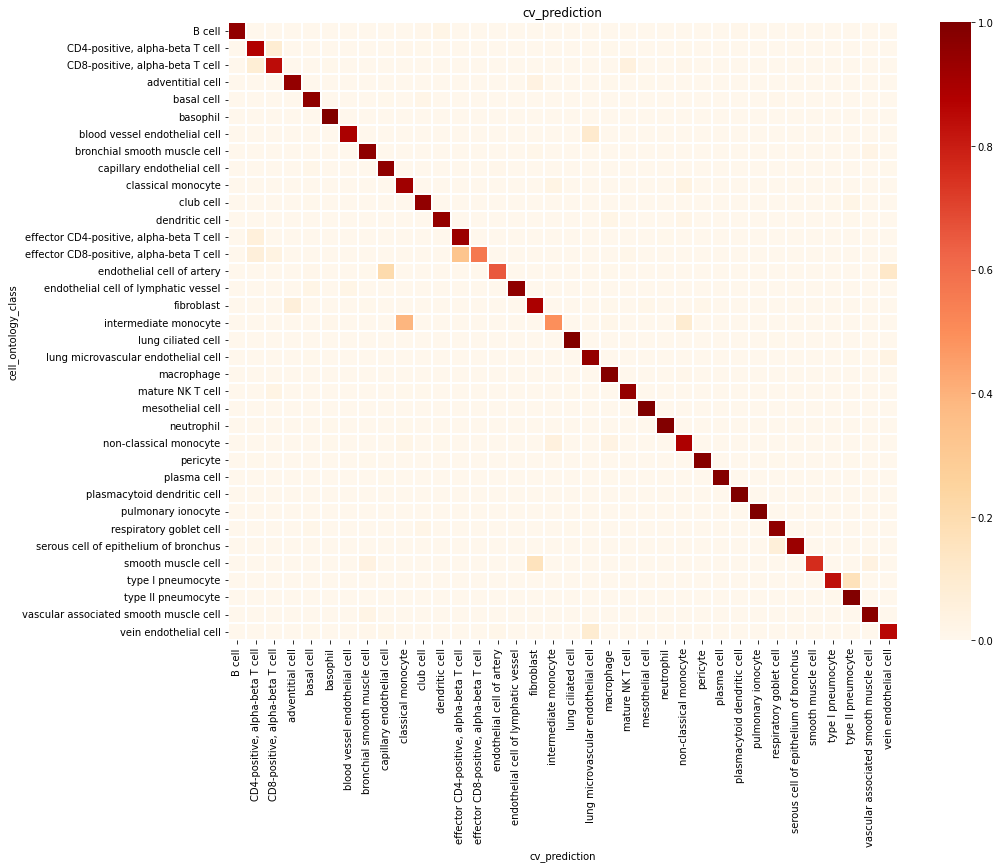

In [7]:
popv.visualization.make_agreement_plots(lung, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

In [8]:
predictors = [i for i in lung.obs.columns if 'popv' in i]

Making confusion matrix for popv_knn_on_bbknn_prediction


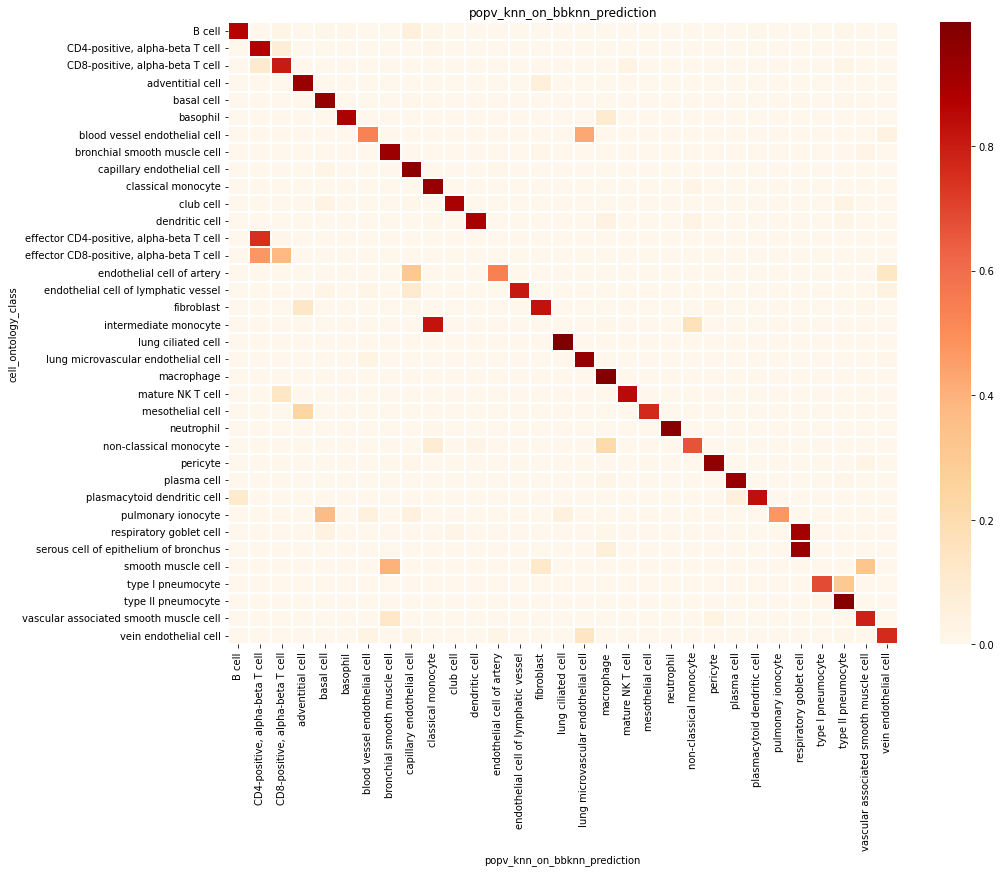

Making confusion matrix for popv_knn_on_scanorama_prediction


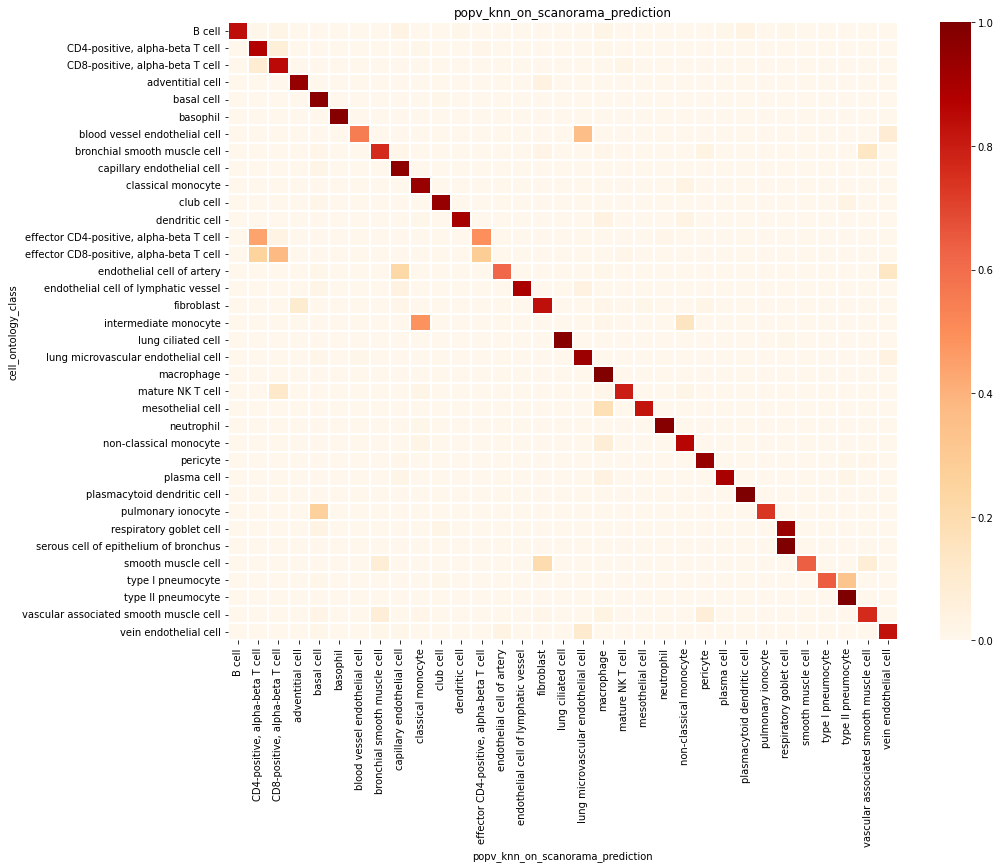

Making confusion matrix for popv_onclass_seen


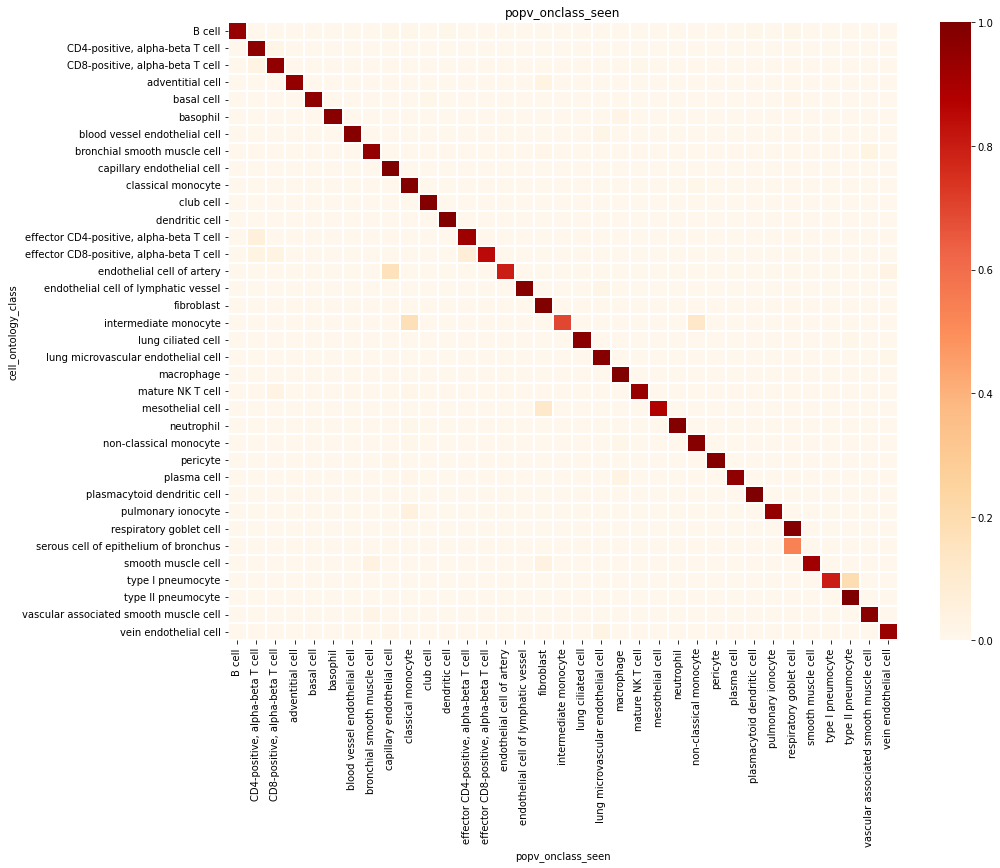

Making confusion matrix for popv_svm_prediction


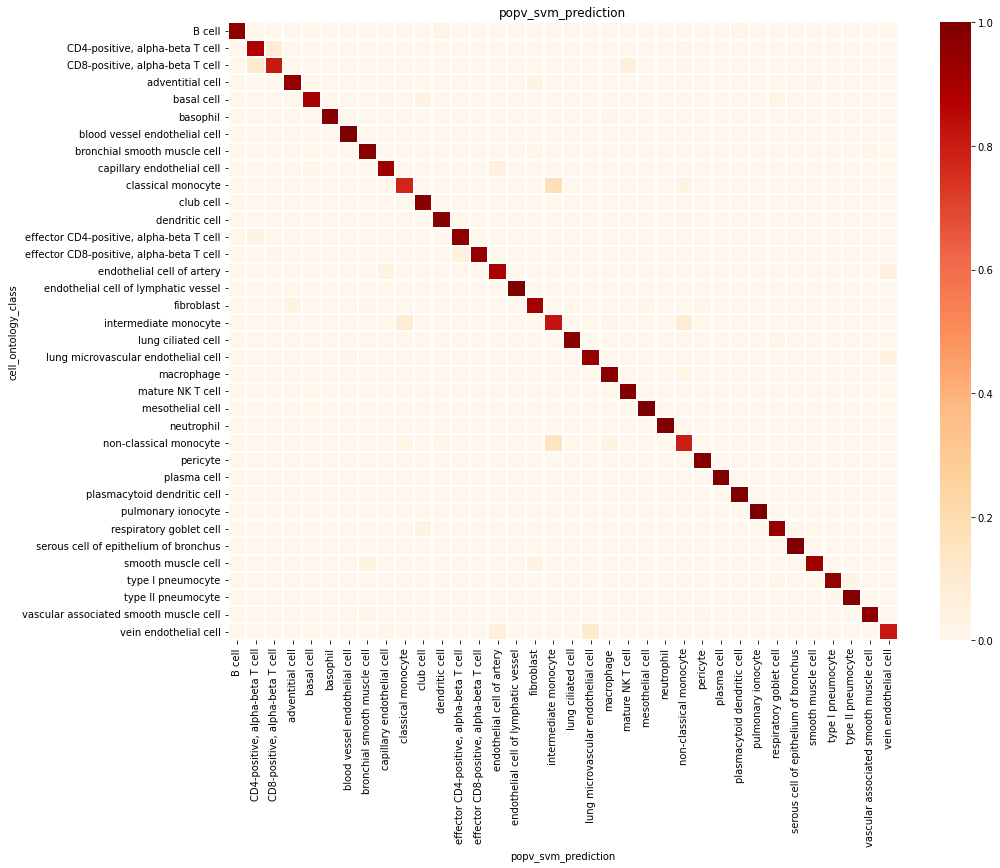

Making confusion matrix for popv_celltypist_prediction


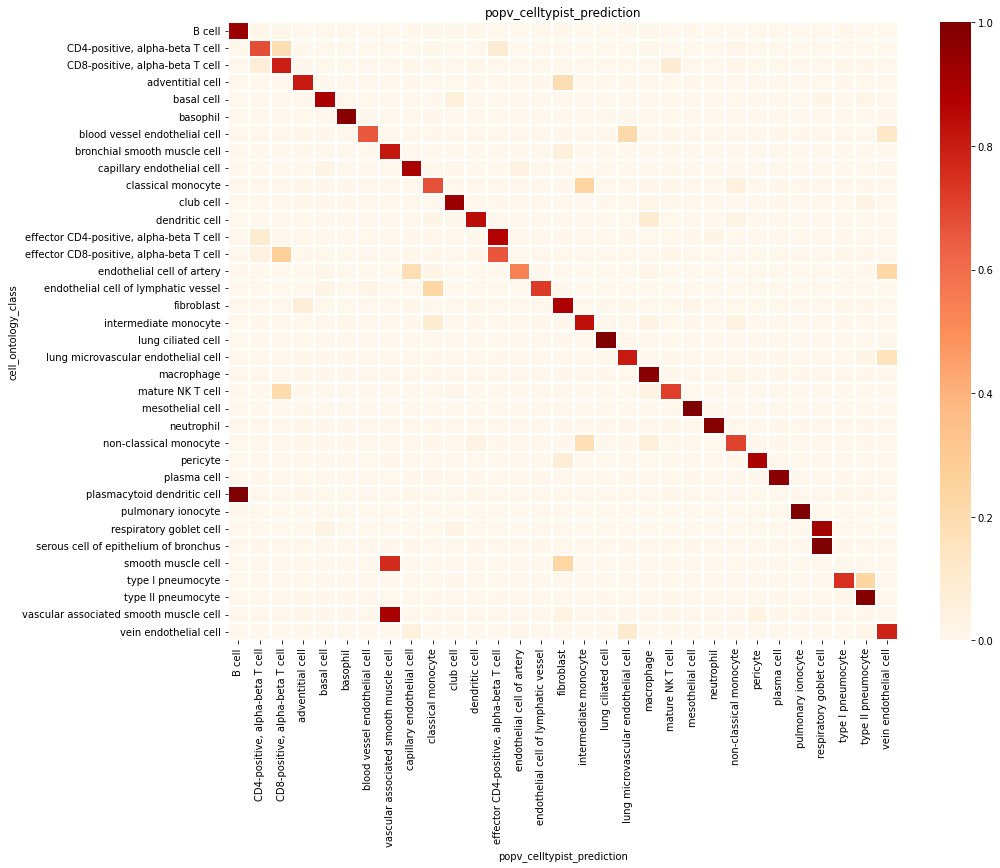

Making confusion matrix for popv_onclass_prediction


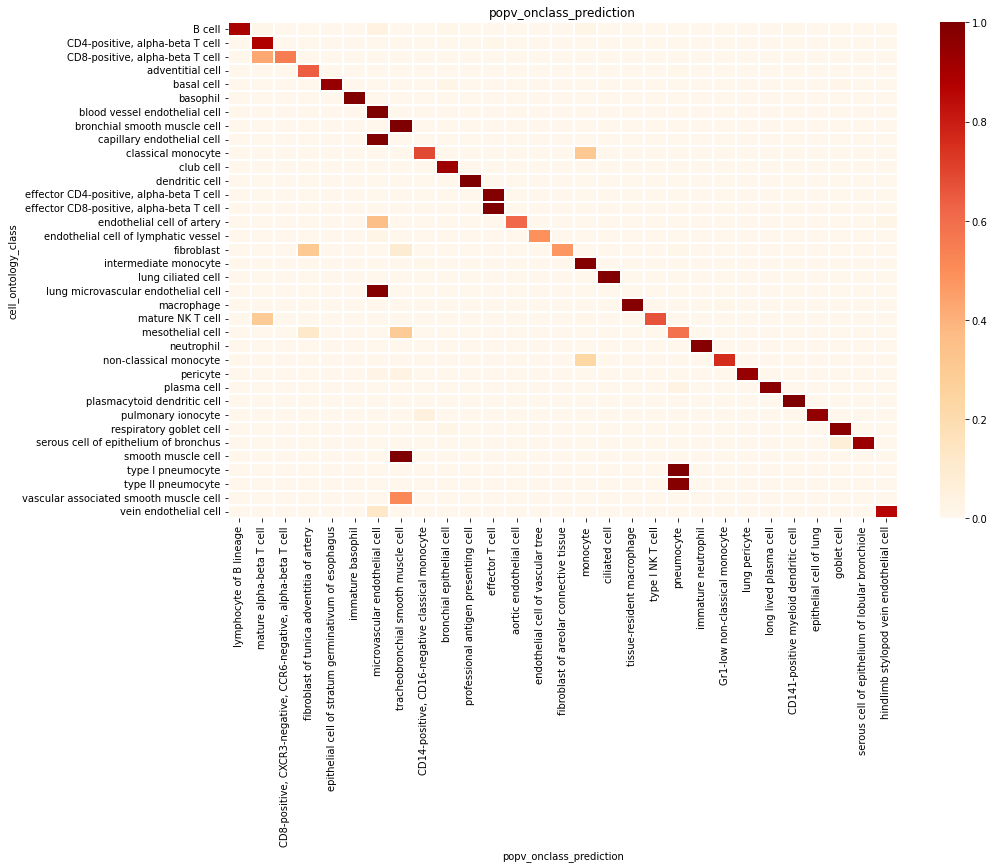

Making confusion matrix for popv_scanvi_prediction


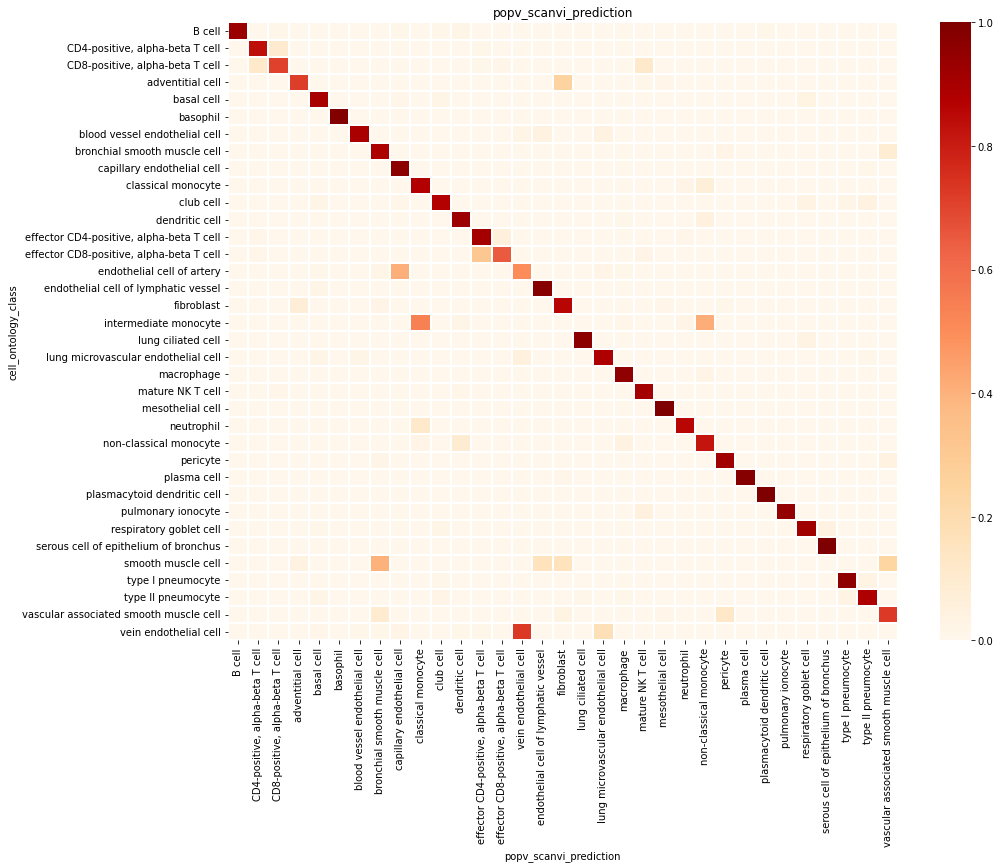

Making confusion matrix for popv_knn_on_scvi_prediction


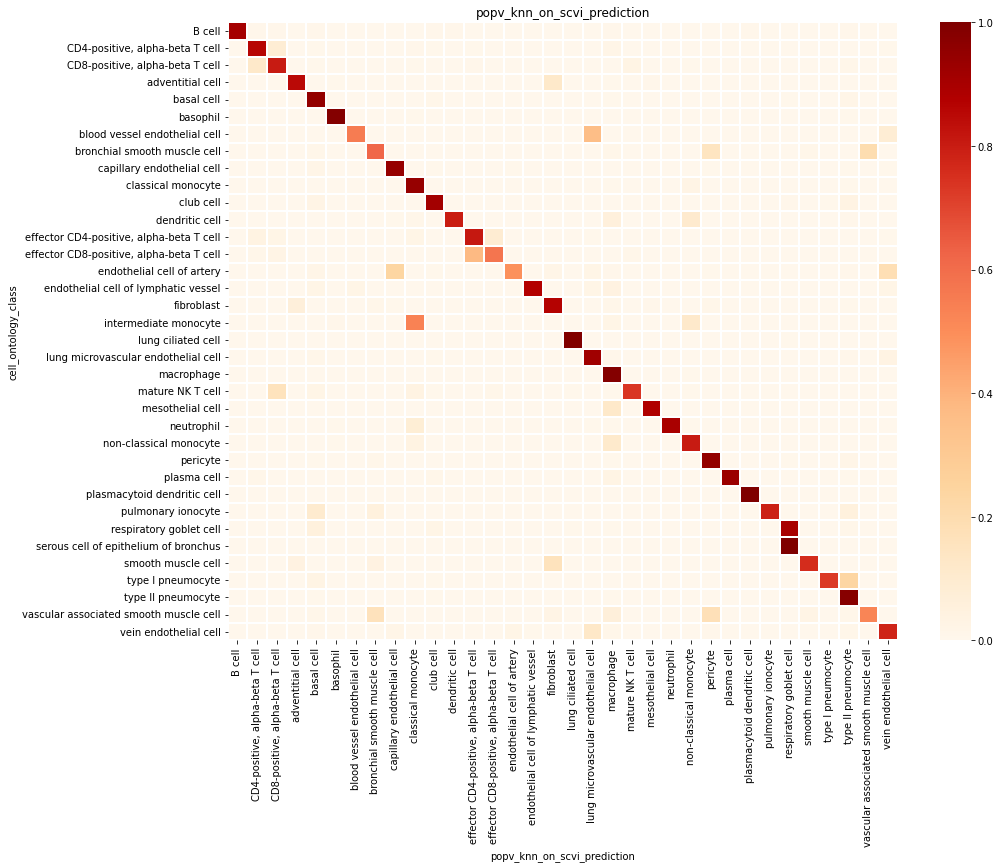

Making confusion matrix for popv_rf_prediction


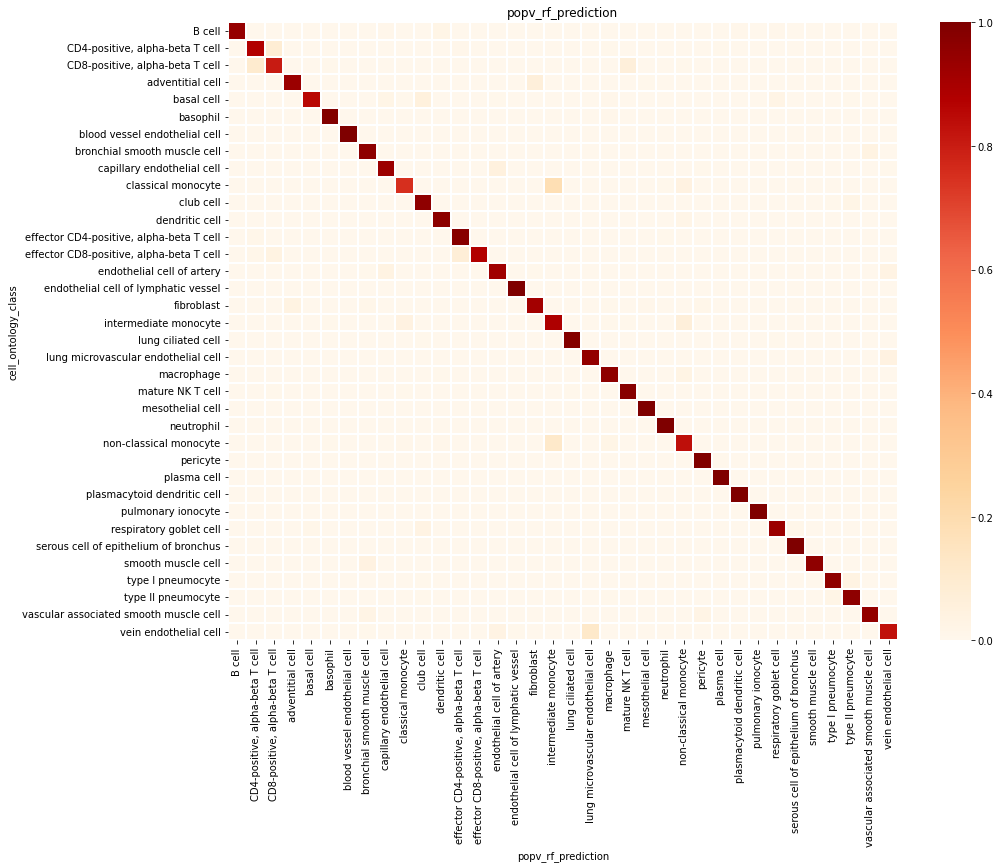

In [9]:
popv.visualization.make_agreement_plots(lung, prediction_keys=predictors, popv_prediction_key='cell_ontology_class', save_folder='.')